In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pygad
import logging
import random
from collections import Counter
import seaborn as sns


In [2]:
arr = pd.read_csv("phylo.csv",
                 delimiter=",")
display(arr)

,Unnamed: 0,Phylostratum,GeneID,Zygote,Quadrant,Globular,Heart,Torpedo,Bent,Mature
0,1,1,at1g01040.2,2173.635205,1911.200145,1152.555283,1291.422445,1000.252931,962.977223,1696.427421
1,2,1,at1g01050.1,1501.014084,1817.308557,1665.308874,1564.761244,1496.320663,1114.643547,1071.655487
2,3,1,at1g01070.1,1212.792724,1233.002267,939.200046,929.619501,864.218009,877.206001,894.818917
3,4,1,at1g01080.2,1016.920321,936.383717,1181.338144,1329.473434,1392.642854,1287.974590,861.260488
4,5,1,at1g01090.1,11424.566680,16778.168460,34366.649350,39775.640530,56231.568920,66980.367330,7772.561656
...,...,...,...,...,...,...,...,...,...,...
25255,25256,12,at5g67200.1,721.139701,731.211686,788.833156,815.185775,871.509726,809.404700,749.102579
25256,25257,12,at5g67245.1,1132.810160,1145.611552,1030.842523,1142.514730,1175.351616,985.904374,1147.261206
25257,25258,12,at5g67280.1,731.678348,748.688731,705.033813,622.710117,730.698691,864.307779,774.050852
25258,25259,12,at5g67380.1,14725.097780,2426.968469,2463.236828,2395.512964,1847.669032,1943.984418,5137.928045


In [3]:
ex_data = arr[["Zygote", "Quadrant","Globular","Heart","Torpedo","Bent","Mature"]]


In [4]:
var_ex = ex_data.var(axis=1)/ex_data.mean(axis=1) 
age_weighted = ex_data.mul(arr["Phylostratum"], axis=0)
perc = 1
high_var_ind =  np.argsort(var_ex)[-round(len(var_ex) * perc):]
low_var_ind =  np.argsort(var_ex)[:-round(len(var_ex) * perc)]


In [5]:
high_var_w = age_weighted.iloc[high_var_ind,:]
high_var = ex_data.iloc[high_var_ind,:]
low_var_w = age_weighted.iloc[low_var_ind,:]
low_var = ex_data.iloc[low_var_ind,:]

high_var_w_n = high_var_w.to_numpy()
high_var_n = high_var.to_numpy()
low_var_w_sum = low_var_w.sum(axis=0).to_numpy()
low_var_sum = low_var.sum(axis=0).to_numpy()

In [234]:
def fitness_batch(ga_instance, solution, solution_idx):
    up = np.add(solution.dot(high_var_w_n),np.tile(low_var_w_sum,(solution.shape[0],1)))
    down = np.add(np.tile(low_var_sum,(solution.shape[0],1)), solution.dot(high_var_n))
    avgs = np.divide(up,down)
    num_not_removed = np.sum(solution,axis = 1)
    return - np.var(avgs,axis=1) + (num_not_removed/solution.shape[1]**2*1.e1)
            
    

In [11]:
def fitness(ga_instance, solution, solution_idx):
    up = np.add(high_var_w.iloc[np.where(solution == 1)[0],:].sum(axis=0).to_numpy(),low_var_w_sum)
    down = np.add(low_var_sum, high_var.iloc[np.where(solution == 1)[0],:].sum(axis=0).to_numpy())
    avgs = np.divide(up,down)
    
    return - np.var(avgs) + ((sum(solution)/len(solution))**2)*1.e-1
    

In [12]:
def print_curve(solution,label=None):
    up = np.add(high_var_w.iloc[np.where(solution == 1)[0],:].sum(axis=0).to_numpy(),low_var_w_sum)
    down = np.add(low_var_sum, high_var.iloc[np.where(solution == 1)[0],:].sum(axis=0).to_numpy())
    avgs = np.divide(up,down)
    print(np.var(avgs))
    plt.ylim(3, 3.8)
    plt.plot(list(range(7)),avgs,'-o',label=label)
    if label:
        plt.legend()
    

In [268]:
def create_population(size):
    return np.array([random.choices([0,1], weights=(1, 60), k=high_var.shape[0]) for _  in range(size)])

0.009837646583158657


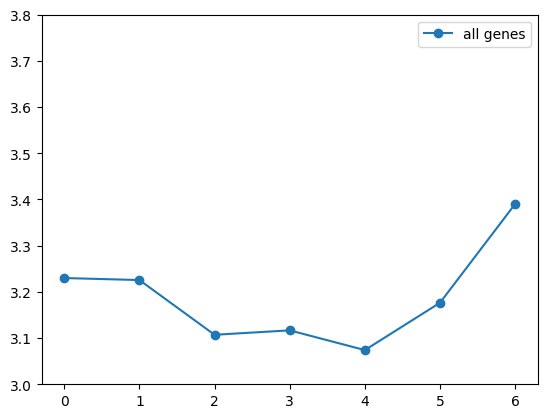

In [15]:
print_curve(np.ones(high_var.shape[0]), label="all genes")

In [179]:
solution = None

In [269]:
"""
level = logging.DEBUG
name = 'logfile.txt'

logger = logging.getLogger(name)
logger.setLevel(level)


console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
console_format = logging.Formatter('%(message)s')
console_handler.setFormatter(console_format)
logger.addHandler(console_handler)
"""
prev_solution = solution
num_threads = 6
population = create_population(170)

ga_instance = pygad.GA(num_generations=200,
                       num_parents_mating=25,
                       fitness_func=fitness_batch,
                       fitness_batch_size=population.shape[0],
                       initial_population=population,
                       crossover_probability=0.07,
                       mutation_probability=0.0002,
                       init_range_low=0,
                       init_range_high=2,
                       gene_type=int,
                       crossover_type="uniform",
                       parallel_processing=["thread", num_threads],
                       save_best_solutions=True,
                       keep_elitism=1
                       )

ga_instance.run()

solution, solution_fitness, solution_idx = ga_instance.best_solution()

4.250295863751395e-06
1104
0.043705463182897863


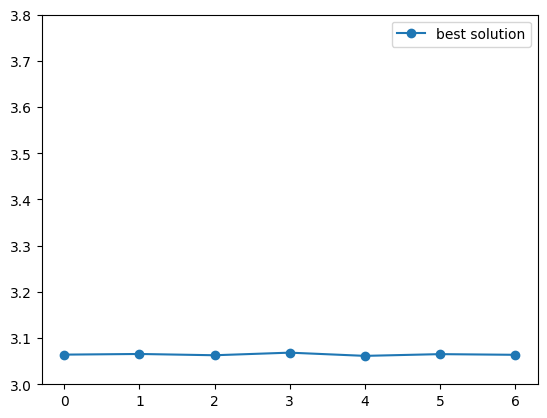

In [270]:
print_curve(solution,label="best solution")
print(len(np.where(solution == 0)[0]))
print(len(np.where(solution == 0)[0])/len(solution))


In [273]:
# in how many generations new best fitness emerged
print(len(set(ga_instance.best_solutions_fitness)))

196


0.0003743302808651075


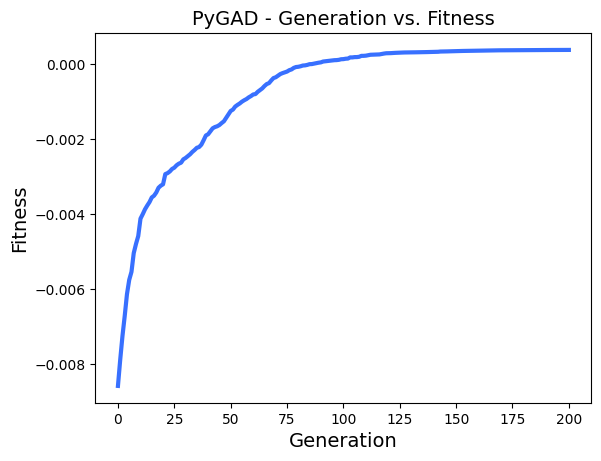

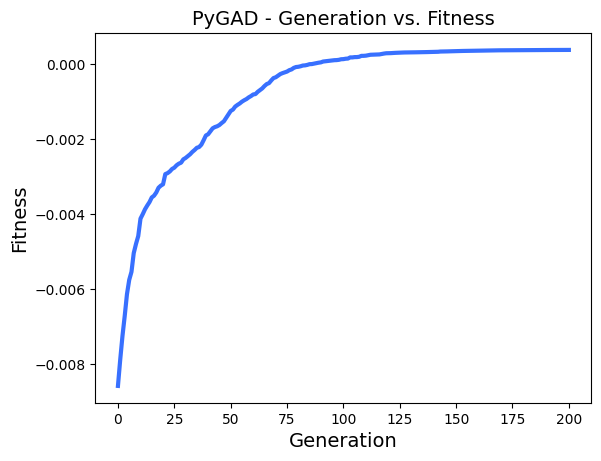

In [271]:
print(solution_fitness)
ga_instance.plot_fitness()

In [272]:

lens = len(solution) - np.sum(np.array(ga_instance.solutions),axis = 1)
fit =fitness_batch(None,np.array(ga_instance.solutions),None)
fit_ind = np.argsort(fitness_batch(None,np.array(ga_instance.solutions),None))
plt.scatter(lens,fit, s=0.1)

AxisError: axis 1 is out of bounds for array of dimension 1

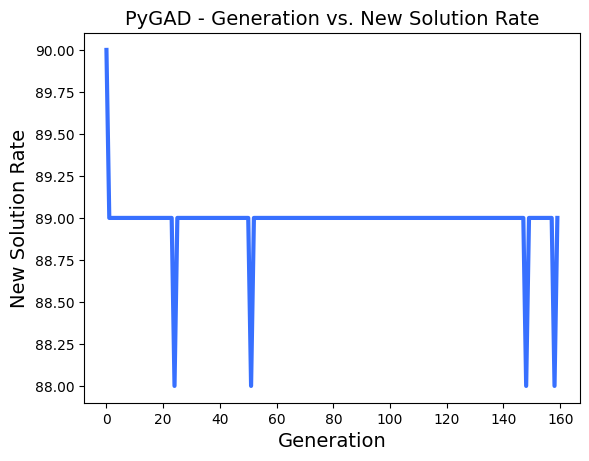

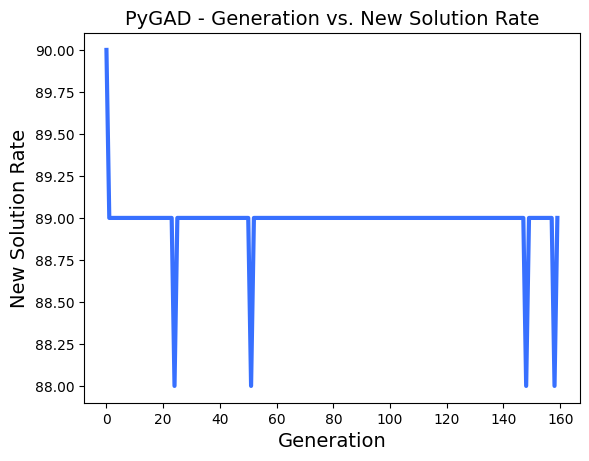

In [191]:
ga_instance.plot_new_solution_rate()

0.009837646583158657


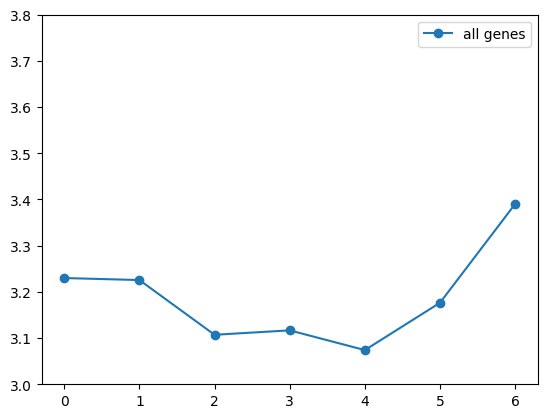

In [532]:
print_curve(np.ones(high_var.shape[0]), label="all genes")

In [192]:
removed_genes =  arr.iloc[high_var.index.values[np.where(solution == 0)[0]],:]
variances = removed_genes.iloc[:, 2:].var(axis=1)
display(removed_genes)

/var/folders/pw/r8s9dk9x4z56sfjh5qm3t8gw0002n8/T/ipykernel_46436/2635158219.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  variances = removed_genes.iloc[:, 2:].var(axis=1)


,Unnamed: 0,Phylostratum,GeneID,Zygote,Quadrant,Globular,Heart,Torpedo,Bent,Mature
2902,2903,1,at2g22890.1,828.008534,847.992614,840.545189,833.570640,833.839155,816.825606,844.762540
18663,18664,4,at5g25415.1,729.448678,751.530732,739.890606,722.444433,726.239194,742.338206,725.139248
12873,12874,2,at3g56570.1,786.644375,792.983856,813.105484,794.062827,818.012546,810.753833,805.911683
13538,13539,2,at4g20330.1,756.942191,734.968451,733.061815,748.369581,741.393580,717.904332,736.007027
12348,12349,2,at3g21470.1,624.026947,603.253463,615.698999,603.782675,635.236317,620.324787,611.497703
...,...,...,...,...,...,...,...,...,...,...
21826,21827,8,at2g42560.1,2457.993370,835.481543,834.124473,760.883619,726.684578,3752.426116,68490.545990
19549,19550,5,at4g09600.1,2841.447558,666.595286,674.684920,694.332357,757.318160,1874.146327,67757.387840
23539,23540,12,at1g07500.1,2236.167648,872.144043,816.071814,852.034298,824.409176,1904.961405,67841.771130
20470,20471,6,at2g42000.2,1222.490371,965.358396,818.341208,932.676571,985.740730,2320.772865,68712.003370


<AxesSubplot: xlabel='Phylostratum', ylabel='Count'>

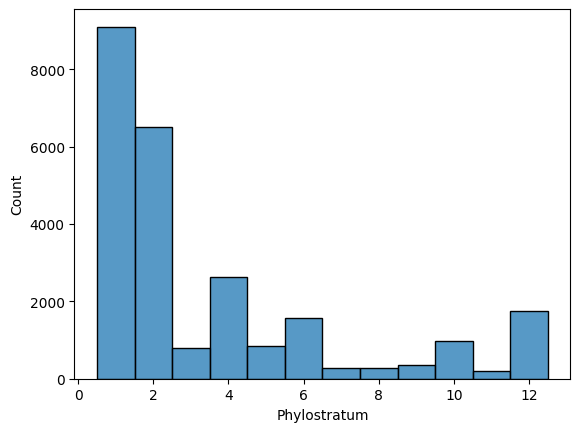

In [198]:
sns.histplot(data=arr,x="Phylostratum",discrete=True)

In [215]:
dff = np.array(list(Counter(removed_genes["Phylostratum"])))/np.array(list(Counter(arr["Phylostratum"])))

In [216]:
dff 

array([1.        , 2.        , 0.66666667, 3.        , 2.        ,
       1.        , 0.71428571, 1.125     , 0.33333333, 0.8       ,
       0.63636364, 0.91666667])

<BarContainer object of 12 artists>

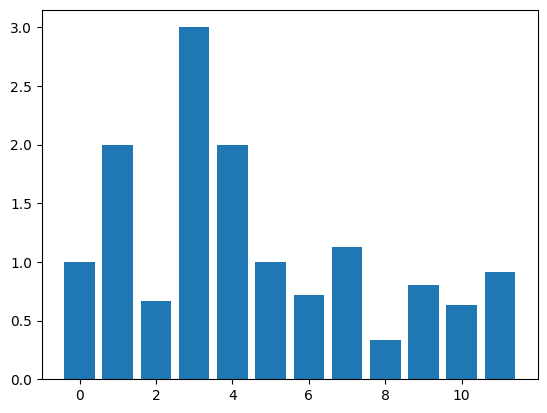

In [222]:
plt.bar(range(len(dff)),dff)

/var/folders/pw/r8s9dk9x4z56sfjh5qm3t8gw0002n8/T/ipykernel_46436/3796282044.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  variances_df = pd.DataFrame(data={'removed': variances, 'removed_cv': variances/removed_genes.iloc[:, 2:].mean(axis=1),'all': ex_data.var(axis=1),'all_cv': ex_data.var(axis=1)/ex_data.mean(axis=1)})


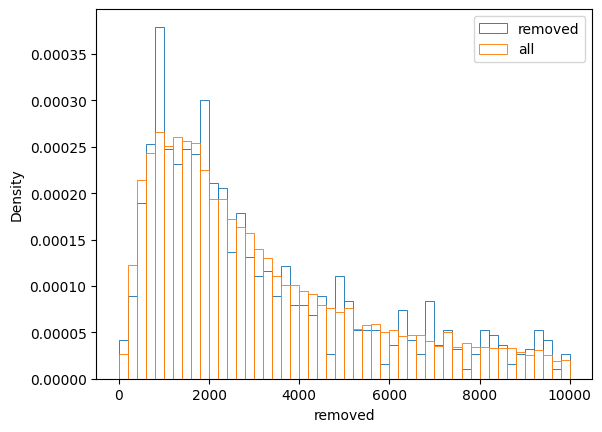

In [197]:
variances_df = pd.DataFrame(data={'removed': variances, 'removed_cv': variances/removed_genes.iloc[:, 2:].mean(axis=1),'all': ex_data.var(axis=1),'all_cv': ex_data.var(axis=1)/ex_data.mean(axis=1)})
sns.histplot(data=variances_df,x="removed",stat="density",binrange=(0,10000),fill=False,common_norm=False,bins=50,label="removed")
sns.histplot(data=variances_df,x="all",stat="density",binrange=(0,10000),fill=False,common_norm=False,bins=50,label="all")
plt.legend()


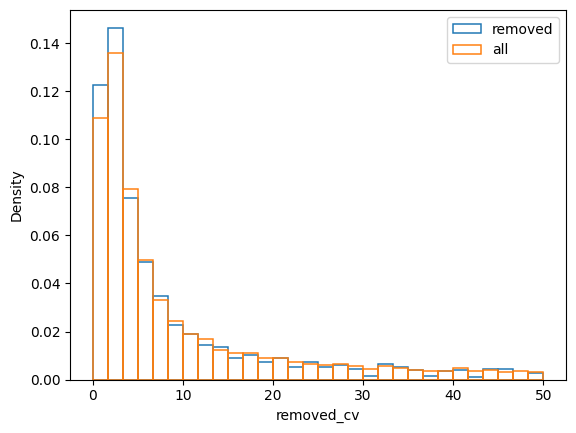

In [196]:
sns.histplot(data=variances_df,x="removed_cv",stat="density",binrange=(0,50),fill=False,common_norm=False,bins=30,label="removed")
sns.histplot(data=variances_df,x="all_cv",stat="density",binrange=(0,50),fill=False,common_norm=False,bins=30,label="all")
plt.legend()
